## Template based decoding

* compute the mean response (response template) per category

* decode the nearest template for each response (over n-1 trials by excluding current trial from template)

* confusion matrix

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_loader import SessionDataLoader

from spikeplot import raster
from spikes.filters import gaussian_filter, exp_filter
from spikes.binning import bin_spikes

from template_decoding import (
    compute_distance_to_templates,
    compute_templates,
    unbias_templates
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_loader = SessionDataLoader("YelBlu6903F", 1)

In [3]:
table = data_loader.load_table()

In [4]:
t_arr, spikes = bin_spikes(table["spike_times"], min_time=0.0, max_time=0.6)
spikes_filtered = gaussian_filter(spikes, 5.0)

table["binned_spikes"] = spikes.tolist()
table["psth"] = spikes_filtered.tolist()

Lets try the pandas groupby function

Include n_trials as a column so we can subtract off 1/n_trials * [single trial psth] to unbias a template

In [21]:
unit_table = table[table["unit"] == (2, 1)]

In [22]:
templates = compute_templates(unit_table, "stim", "psth")

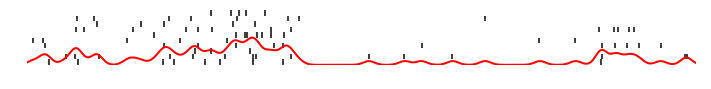

In [23]:
plt.figure(figsize=(12, 1))
raster.plot(unit_table[unit_table["stim"] == "100"]["spike_times"], 0, 0.6)
scale = plt.ylim()[1] / 2.0
plt.plot(
    t_arr,
    scale * templates.get_value("100", "psth") / np.max(templates.get_value("100", "psth")),
    color="red",
    linewidth=2)
plt.axis("off")
plt.show()

In [36]:
unit_table.drop("psth_template", 1, inplace=True)
unit_table = unbias_templates(unit_table, templates, "stim", "psth")

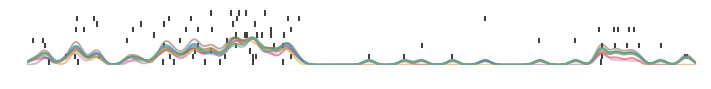

In [37]:
plt.figure(figsize=(12, 1))
raster.plot(unit_table[unit_table["stim"] == "100"]["spike_times"], 0, 0.6)
scale = plt.ylim()[1] / 2.0

for psth in unit_table[unit_table["stim"] == "100"]["selfless_template"]:
    plt.plot(
        t_arr,
        scale * np.array(psth) / np.max(psth),
        linewidth=2,
        alpha=0.5)
    
plt.axis("off")
plt.show()

In [154]:
distances = compute_distance_to_templates(unit_table, "stim")